気温のみをまずは予測するモデル、日時と気温を特徴量にkwを予測するモデルを別に構築する。  
予測した気温を特徴量にして、直接kwを予測する  
結果はRMSE:126

In [148]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [149]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [150]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 準備

In [199]:
data_21 = pd.read_csv("./data/power_demand/juyo-2021.csv", encoding="SHIFT-JIS", skiprows=2)
data_20 = pd.read_csv("./data/power_demand/juyo-2020.csv", encoding="SHIFT-JIS", skiprows=2)
data_19 = pd.read_csv("./data/power_demand/juyo-2019.csv", encoding="SHIFT-JIS", skiprows=2)
data_18 = pd.read_csv("./data/power_demand/juyo-2018.csv", encoding="SHIFT-JIS", skiprows=2)

In [200]:
data_18

,DATE,TIME,実績(万kW)
0,2018/1/1,0:00,2962
1,2018/1/1,1:00,2797
2,2018/1/1,2:00,2669
3,2018/1/1,3:00,2586
4,2018/1/1,4:00,2543
...,...,...,...
8755,2018/12/31,19:00,3531
8756,2018/12/31,20:00,3473
8757,2018/12/31,21:00,3376
8758,2018/12/31,22:00,3252


In [201]:
data = pd.concat([data_18, data_19, data_20, data_21])
data.reset_index(drop=True, inplace=True)
data.rename(columns={"実績(万kW)":"kw"}, inplace=True)

tmp_list = []
for date,time in  zip(data["DATE"], data["TIME"]):
    strdate = date + " " + time
    tmp_list.append(dt.datetime.strptime(strdate, "%Y/%m/%d %H:%M"))
    
data["datetime"] = tmp_list

In [202]:
data["month"] = data["DATE"].map(lambda x : x.split("/")[1])
data["day"] = data["DATE"].map(lambda x : x.split("/")[-1])
data["hour"] = data["TIME"].map(lambda x : x.split(":")[0])
data["weekday"] = data["datetime"].map(lambda x : dt.datetime.weekday(x))

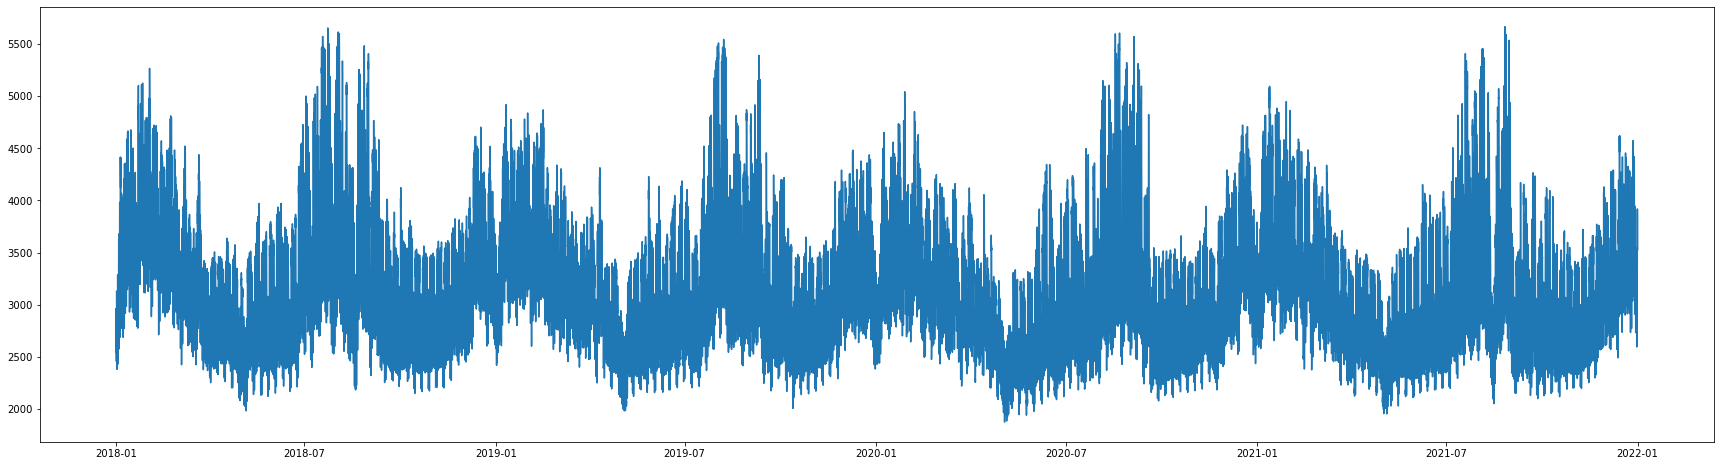

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,8))
plt.plot(data["datetime"], data["kw"])
plt.show()

In [204]:
weather_18_0 = pd.read_csv("./data/weather/tokyo_2018/with_temperature.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_18_1 = pd.read_csv("./data/weather/tokyo_2018/with_precipitation.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_18_2 = pd.read_csv("./data/weather/tokyo_2018/with_weather.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_18_3 = pd.read_csv("./data/weather/tokyo_2018/with_humidity.csv", encoding="SHIFT-JIS", skiprows=1).iloc[2:,:2]
weather_18_3.rename(columns={"Unnamed: 0":"年月日時", "東京":"湿度"}, inplace=True)
weather_18_3.reset_index(drop=True, inplace=True)
data18 = weather_18_0.join([weather_18_1.iloc[:, 1], weather_18_2.iloc[:, 1], weather_18_3.iloc[:, 1]])

weather_19_0 = pd.read_csv("./data/weather/tokyo_2019/with_temperature.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_19_1 = pd.read_csv("./data/weather/tokyo_2019/with_precipitation.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_19_2 = pd.read_csv("./data/weather/tokyo_2019/with_weather.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_19_3 = pd.read_csv("./data/weather/tokyo_2019/with_humidity.csv", encoding="SHIFT-JIS", skiprows=1).iloc[2:,:2]
weather_19_3.rename(columns={"Unnamed: 0":"年月日時", "東京":"湿度"}, inplace=True)
weather_19_3.reset_index(drop=True, inplace=True)
data19 = weather_19_0.join([weather_19_1.iloc[:, 1], weather_19_2.iloc[:, 1], weather_19_3.iloc[:, 1]])

weather_20_0 = pd.read_csv("./data/weather/tokyo_2020/with_temperature.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_20_1 = pd.read_csv("./data/weather/tokyo_2020/with_precipitation.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_20_2 = pd.read_csv("./data/weather/tokyo_2020/with_weather.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_20_3 = pd.read_csv("./data/weather/tokyo_2020/with_humidity.csv", encoding="SHIFT-JIS", skiprows=1).iloc[2:,:2]
weather_20_3.rename(columns={"Unnamed: 0":"年月日時", "東京":"湿度"}, inplace=True)
weather_20_3.reset_index(drop=True, inplace=True)
data20 = weather_20_0.join([weather_20_1.iloc[:, 1], weather_20_2.iloc[:, 1], weather_20_3.iloc[:, 1]])

weather_21_0 = pd.read_csv("./data/weather/tokyo_2021/with_temperature.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_21_1 = pd.read_csv("./data/weather/tokyo_2021/with_precipitation.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_21_2 = pd.read_csv("./data/weather/tokyo_2021/with_weather.csv", encoding="SHIFT-JIS", skiprows=3).iloc[1:,:2]
weather_21_3 = pd.read_csv("./data/weather/tokyo_2021/with_humidity.csv", encoding="SHIFT-JIS", skiprows=1).iloc[2:,:2]
weather_21_3.rename(columns={"Unnamed: 0":"年月日時", "東京":"湿度"}, inplace=True)
weather_21_3.reset_index(drop=True, inplace=True)
data21 = weather_21_0.join([weather_21_1.iloc[:, 1], weather_21_2.iloc[:, 1], weather_21_3.iloc[:, 1]])

weather_data = pd.concat([data18, data19, data20, data21])
weather_data.reset_index(drop=True, inplace=True)

天気の項目は毎日3, 6, 9, 12, 15, 18, 21時しか観測されていない

In [205]:
data18

,年月日時,気温(℃),降水量(mm),天気,湿度
1,2018/1/1 1:00:00,1.5,0.0,NaN,83
2,2018/1/1 2:00:00,1.0,0.0,NaN,80
3,2018/1/1 3:00:00,1.2,0.0,1.0,85
4,2018/1/1 4:00:00,0.6,0.0,NaN,80
5,2018/1/1 5:00:00,1.9,0.0,NaN,78
...,...,...,...,...,...
8756,2018/12/31 20:00:00,5.3,0.0,NaN,43
8757,2018/12/31 21:00:00,4.8,0.0,1.0,47
8758,2018/12/31 22:00:00,4.2,0.0,NaN,45
8759,2018/12/31 23:00:00,4.6,0.0,NaN,54


In [206]:
start_num = 0
weather_list = []
for _ in range(int(weather_data.shape[0]/24)):
    tmp_df = weather_data.iloc[start_num: start_num+24, 3]
    tmp_df.reset_index(drop=True, inplace=True)
    for _ in range(4):
        weather_list.append(tmp_df[2])
    for _ in range(3):
        weather_list.append(tmp_df[5])
    for _ in range(3):
        weather_list.append(tmp_df[8])
    for _ in range(3):
        weather_list.append(tmp_df[11])
    for _ in range(3):
        weather_list.append(tmp_df[14])
    for _ in range(3):
        weather_list.append(tmp_df[17])
    for _ in range(5):
        weather_list.append(tmp_df[20])
    start_num += 24

weather_data["天気"] = weather_list

weather_data["年月日時"] = weather_data["年月日時"].map(lambda x : dt.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))
weather_data.rename(columns={"年月日時":"datetime"}, inplace=True)

In [207]:
weather_data

,datetime,気温(℃),降水量(mm),天気,湿度
0,2018-01-01 01:00:00,1.5,0.0,1.0,83
1,2018-01-01 02:00:00,1.0,0.0,1.0,80
2,2018-01-01 03:00:00,1.2,0.0,1.0,85
3,2018-01-01 04:00:00,0.6,0.0,1.0,80
4,2018-01-01 05:00:00,1.9,0.0,1.0,78
...,...,...,...,...,...
35059,2021-12-31 20:00:00,1.0,0.0,1.0,44
35060,2021-12-31 21:00:00,1.4,0.0,1.0,47
35061,2021-12-31 22:00:00,0.7,0.0,1.0,43
35062,2021-12-31 23:00:00,0.6,0.0,1.0,44


In [208]:
df = pd.merge(data, weather_data, how="left", on="datetime")
# 2019/01/01 00:00(0行目)の天気情報データが無かったので削除
df = df.iloc[1:, :].reset_index(drop=True)
df.rename(columns={"DATE":"date", "TIME":"time", "気温(℃)":"temperature", "降水量(mm)":"precipitation", "天気":"weather", "湿度":"humidity"}, inplace=True)

In [209]:
df.describe()

,kw,weekday,temperature,precipitation,weather
count,35063.000000,35063.000000,35059.000000,35063.000000,35063.000000
mean,3237.967059,2.996663,16.638250,0.198557,3.694322
std,667.338689,1.999134,8.171977,1.138242,2.894676
min,1877.000000,0.000000,-3.600000,0.000000,1.000000
25%,2715.000000,1.000000,9.800000,0.000000,2.000000
50%,3178.000000,3.000000,17.000000,0.000000,3.000000
75%,3649.000000,5.000000,23.100000,0.000000,4.000000
max,5665.000000,6.000000,37.400000,31.000000,15.000000


データdescribe4時間 * 365日 * 3年 + 24時間(うるう年2/29の1日分) - 1件(先頭) で35,063件

In [194]:
df.shape

(35063, 12)

In [195]:
df

,date,time,kw,datetime,month,day,hour,weekday,temperature,precipitation,weather,humidity
0,2018/1/1,1:00,2797,2018-01-01 01:00:00,1,1,1,0,1.5,0.0,1.0,83
1,2018/1/1,2:00,2669,2018-01-01 02:00:00,1,1,2,0,1.0,0.0,1.0,80
2,2018/1/1,3:00,2586,2018-01-01 03:00:00,1,1,3,0,1.2,0.0,1.0,85
3,2018/1/1,4:00,2543,2018-01-01 04:00:00,1,1,4,0,0.6,0.0,1.0,80
4,2018/1/1,5:00,2570,2018-01-01 05:00:00,1,1,5,0,1.9,0.0,1.0,78
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,2021/12/31,19:00,3888,2021-12-31 19:00:00,12,31,19,4,1.5,0.0,2.0,50
35059,2021/12/31,20:00,3823,2021-12-31 20:00:00,12,31,20,4,1.0,0.0,1.0,44
35060,2021/12/31,21:00,3717,2021-12-31 21:00:00,12,31,21,4,1.4,0.0,1.0,47
35061,2021/12/31,22:00,3589,2021-12-31 22:00:00,12,31,22,4,0.7,0.0,1.0,43


In [27]:
#天気一覧から辞書を作成
#晴れや快晴･･･0.0, 曇り･･･0.5, 雨や雷･･･1.0　のように出かけにくさを数値化
w_dic = {1:0.0, 2:0.0, 3:0.3, 4:0.5, 5:0.6, 6:1.0, 7:1.0, 8:0.6, 9:0.7, 10:1.0, 11:1.0, 12:1.0, 13:1.0, 14:1.0, 15:1.0, 16:0.8, 17:1.0, 18:0.8, 19:1.0, 22:1.0, 23:1.0, 24:1.0, 28:0.6, 101:1.0}

In [28]:
# "weather"列を0から1に変換
df["weather"] = df["weather"].astype("int").map(lambda x: w_dic[x])

In [29]:
df.isnull().sum()

date              0
time              0
kw                0
datetime          0
month             0
day               0
hour              0
weekday           0
temperature       4
precipitation     0
weather           0
humidity         39
dtype: int64

In [30]:
#欠損値を直前の値で補完
df = df.fillna(method="pad")
df["weekday"] = df["weekday"].astype("object")
df["humidity"] = df["humidity"].map(lambda x : int(x)/100)

In [31]:
df

,date,time,kw,datetime,month,day,hour,weekday,temperature,precipitation,weather,humidity
0,2018/1/1,1:00,2797,2018-01-01 01:00:00,1,1,1,0,1.5,0.0,0.0,0.83
1,2018/1/1,2:00,2669,2018-01-01 02:00:00,1,1,2,0,1.0,0.0,0.0,0.80
2,2018/1/1,3:00,2586,2018-01-01 03:00:00,1,1,3,0,1.2,0.0,0.0,0.85
3,2018/1/1,4:00,2543,2018-01-01 04:00:00,1,1,4,0,0.6,0.0,0.0,0.80
4,2018/1/1,5:00,2570,2018-01-01 05:00:00,1,1,5,0,1.9,0.0,0.0,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,2021/12/31,19:00,3888,2021-12-31 19:00:00,12,31,19,4,1.5,0.0,0.0,0.50
35059,2021/12/31,20:00,3823,2021-12-31 20:00:00,12,31,20,4,1.0,0.0,0.0,0.44
35060,2021/12/31,21:00,3717,2021-12-31 21:00:00,12,31,21,4,1.4,0.0,0.0,0.47
35061,2021/12/31,22:00,3589,2021-12-31 22:00:00,12,31,22,4,0.7,0.0,0.0,0.43


In [32]:
df.isnull().sum()

date             0
time             0
kw               0
datetime         0
month            0
day              0
hour             0
weekday          0
temperature      0
precipitation    0
weather          0
humidity         0
dtype: int64

In [33]:
df.dtypes

date                     object
time                     object
kw                        int64
datetime         datetime64[ns]
month                    object
day                      object
hour                     object
weekday                  object
temperature             float64
precipitation           float64
weather                 float64
humidity                float64
dtype: object

<AxesSubplot:>

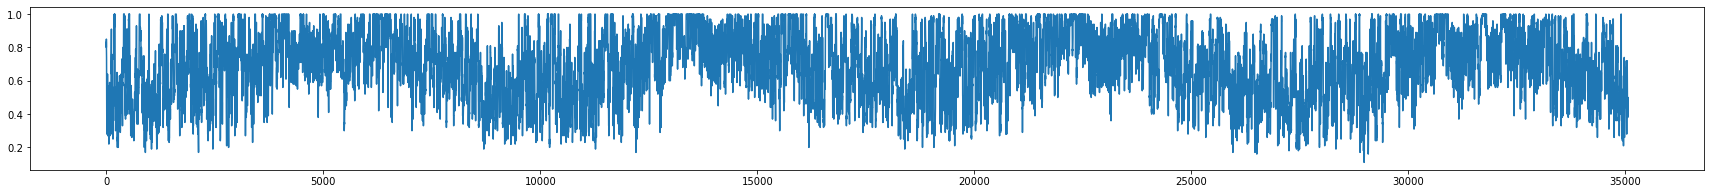

In [34]:
df["humidity"].plot(figsize=(30,3))

<AxesSubplot:>

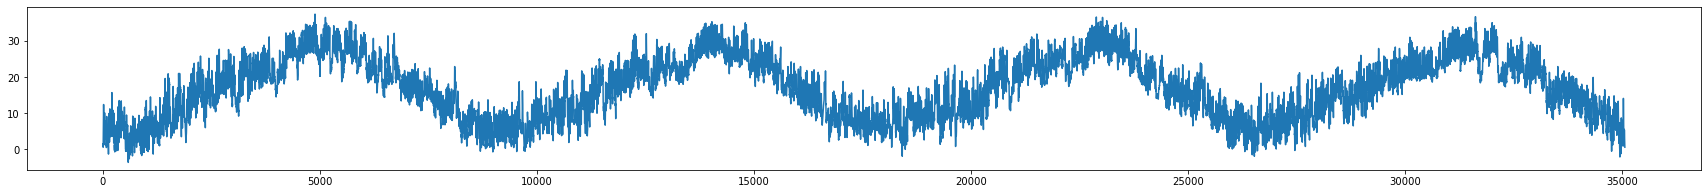

In [35]:
df["temperature"].plot(figsize=(30,3))

<AxesSubplot:>

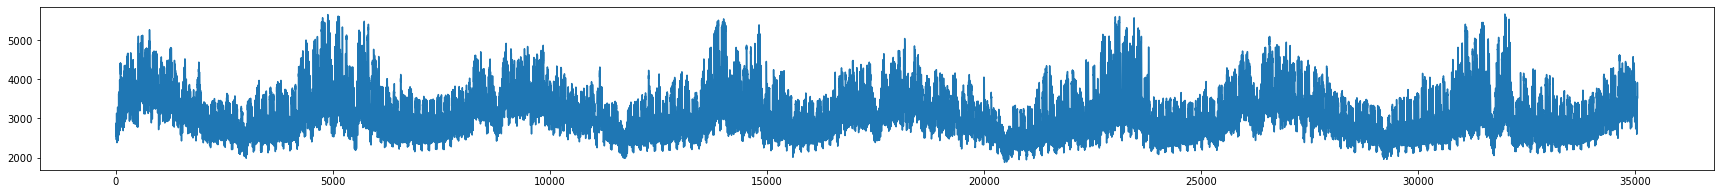

In [36]:
df["kw"].plot(figsize=(30,3))

In [37]:
df.corr()

,kw,temperature,precipitation,weather,humidity
kw,1.000000,0.078719,-0.036166,-0.100050,-0.254606
temperature,0.078719,1.000000,0.008084,0.072693,0.265802
precipitation,-0.036166,0.008084,1.000000,0.310813,0.242769
weather,-0.100050,0.072693,0.310813,1.000000,0.563888
humidity,-0.254606,0.265802,0.242769,0.563888,1.000000


In [38]:
df

,date,time,kw,datetime,month,day,hour,weekday,temperature,precipitation,weather,humidity
0,2018/1/1,1:00,2797,2018-01-01 01:00:00,1,1,1,0,1.5,0.0,0.0,0.83
1,2018/1/1,2:00,2669,2018-01-01 02:00:00,1,1,2,0,1.0,0.0,0.0,0.80
2,2018/1/1,3:00,2586,2018-01-01 03:00:00,1,1,3,0,1.2,0.0,0.0,0.85
3,2018/1/1,4:00,2543,2018-01-01 04:00:00,1,1,4,0,0.6,0.0,0.0,0.80
4,2018/1/1,5:00,2570,2018-01-01 05:00:00,1,1,5,0,1.9,0.0,0.0,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,2021/12/31,19:00,3888,2021-12-31 19:00:00,12,31,19,4,1.5,0.0,0.0,0.50
35059,2021/12/31,20:00,3823,2021-12-31 20:00:00,12,31,20,4,1.0,0.0,0.0,0.44
35060,2021/12/31,21:00,3717,2021-12-31 21:00:00,12,31,21,4,1.4,0.0,0.0,0.47
35061,2021/12/31,22:00,3589,2021-12-31 22:00:00,12,31,22,4,0.7,0.0,0.0,0.43


In [39]:
df.to_csv("./data/df_ver1.csv", index=False)

# 再開はここから

In [151]:
df = pd.read_csv("./data/df_ver1.csv")

In [152]:
df

,date,time,kw,datetime,month,day,hour,weekday,temperature,precipitation,weather,humidity
0,2018/1/1,1:00,2797,2018-01-01 01:00:00,1,1,1,0,1.5,0.0,0.0,0.83
1,2018/1/1,2:00,2669,2018-01-01 02:00:00,1,1,2,0,1.0,0.0,0.0,0.80
2,2018/1/1,3:00,2586,2018-01-01 03:00:00,1,1,3,0,1.2,0.0,0.0,0.85
3,2018/1/1,4:00,2543,2018-01-01 04:00:00,1,1,4,0,0.6,0.0,0.0,0.80
4,2018/1/1,5:00,2570,2018-01-01 05:00:00,1,1,5,0,1.9,0.0,0.0,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,2021/12/31,19:00,3888,2021-12-31 19:00:00,12,31,19,4,1.5,0.0,0.0,0.50
35059,2021/12/31,20:00,3823,2021-12-31 20:00:00,12,31,20,4,1.0,0.0,0.0,0.44
35060,2021/12/31,21:00,3717,2021-12-31 21:00:00,12,31,21,4,1.4,0.0,0.0,0.47
35061,2021/12/31,22:00,3589,2021-12-31 22:00:00,12,31,22,4,0.7,0.0,0.0,0.43


In [153]:
kw = df["kw"]
df = df.iloc[:,4:9]
df["kw"] = kw

In [154]:
df.head()

,month,day,hour,weekday,temperature,kw
0,1,1,1,0,1.5,2797
1,1,1,2,0,1.0,2669
2,1,1,3,0,1.2,2586
3,1,1,4,0,0.6,2543
4,1,1,5,0,1.9,2570


In [155]:
data = df.values

In [156]:
# 全体の約17%をtestデータとして分割
# 2021/4/30 23時のデータまでをtrainに
timesteps = 6

train_size = 29183
train = data[:train_size, :]
test = data[train_size-timesteps:, :]

In [157]:
train.shape, test.shape

((29183, 6), (5886, 6))

In [158]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
train = mms.fit_transform(train)
test = mms.transform(test)

In [159]:
x_train = train[:, :-1]
y_train = train[:, -1].reshape(-1,1)
x_test = test[:, :-1]
y_test = test[:, -1].reshape(-1,1)

In [160]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((29183, 5), (29183, 1), (5886, 5), (5886, 1))

In [161]:
data_x = []
for i in range(x_train.shape[0]-timesteps):
    timedelta_x = []
    for j in range(x_train.shape[1]):
        timedelta_x.append(x_train[i:i+timesteps, j])
    timedelta_x = np.array(timedelta_x)
    timedelta_x = timedelta_x.transpose()
    data_x.append(timedelta_x)

x_train = np.array(data_x)
y_train = y_train[6:]

In [162]:
data_x = []
for i in range(x_test.shape[0]-timesteps):
    timedelta_x = []    
    for j in range(x_test.shape[1]):
        timedelta_x.append(x_test[i:i+timesteps, j])
    timedelta_x = np.array(timedelta_x)
    timedelta_x = timedelta_x.transpose()
    data_x.append(timedelta_x)

x_test = np.array(data_x)
y_test = y_test[6:]

In [163]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((29177, 6, 5), (29177, 1), (5880, 6, 5), (5880, 1))

In [164]:
#気温を予測するためのデータセット
x_train_temp = x_train[:, :, :-1]
y_train_temp = train[6:, -2].reshape(-1,1)
x_test_temp = x_test[:, :, :-1]
y_test_temp = test[6:, -2].reshape(-1,1)

In [165]:
x_train_temp.shape, y_train_temp.shape, x_test_temp.shape, y_test_temp.shape

((29177, 6, 4), (29177, 1), (5880, 6, 4), (5880, 1))

# 学習

## GRU_stack_2

In [167]:
%%time
neuron = 256
actfunc = "tanh"
dropout = 0.2
epochs = 300

model = Sequential()
model.add(GRU(neuron, activation=actfunc, batch_input_shape=(None, timesteps, x_train.shape[2]), return_sequences=True))
model.add(Dropout(dropout))
model.add(GRU(neuron, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(y_train.shape[1], activation="linear")) 

model.compile(loss="mean_squared_error", optimizer="adam")
early_stopping =  EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5)

history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/300
183/183 [==============================] - 18s 75ms/step - loss: 0.0188 - val_loss: 0.0050
Epoch 2/300
183/183 [==============================] - 12s 67ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 3/300
183/183 [==============================] - 14s 78ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 4/300
183/183 [==============================] - 14s 77ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 5/300
183/183 [==============================] - 15s 79ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 6/300
183/183 [==============================] - 17s 95ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 7/300
183/183 [==============================] - 24s 132ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 8/300
183/183 [==============================] - 26s 143ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 9/300
183/183 [==============================] - 29s 160ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 10/300
183/183 [==============================] - 29s 156ms/step

In [168]:
time_GRU_stack_2 = 278

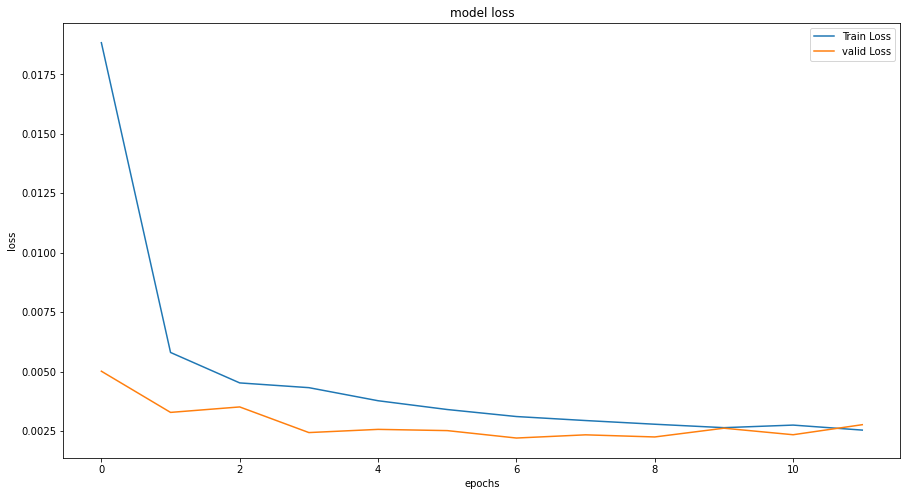

In [169]:
plt.figure(figsize=(15,8))
plt.plot(history_GRU_stack_2.history['loss'], label='Train Loss')
plt.plot(history_GRU_stack_2.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [176]:
pred = model.predict(x_test)
pred = np.concatenate([test[timesteps:, :-1], pred], 1)
y_test_pred = mms.inverse_transform(pred)[:744,-1]

y_t = np.concatenate([test[timesteps:, :-1], y_test], 1)
y_t = mms.inverse_transform(y_t)[:744,-1]

RMSE = np.sqrt(mean_squared_error(y_t, y_test_pred))
MAE = mean_absolute_error(y_t, y_test_pred)
MAPE = mean_absolute_percentage_error(y_t, y_test_pred)

# 指標出力
print('RMSE:')
print(RMSE)
print('MAE:')
print(MAE) 
print('MAPE:')
print(MAPE) 

184/184 [==============================] - 3s 16ms/step
RMSE:
132.90085134690722
MAE:
101.48311593455654
MAPE:
0.03775352766323238


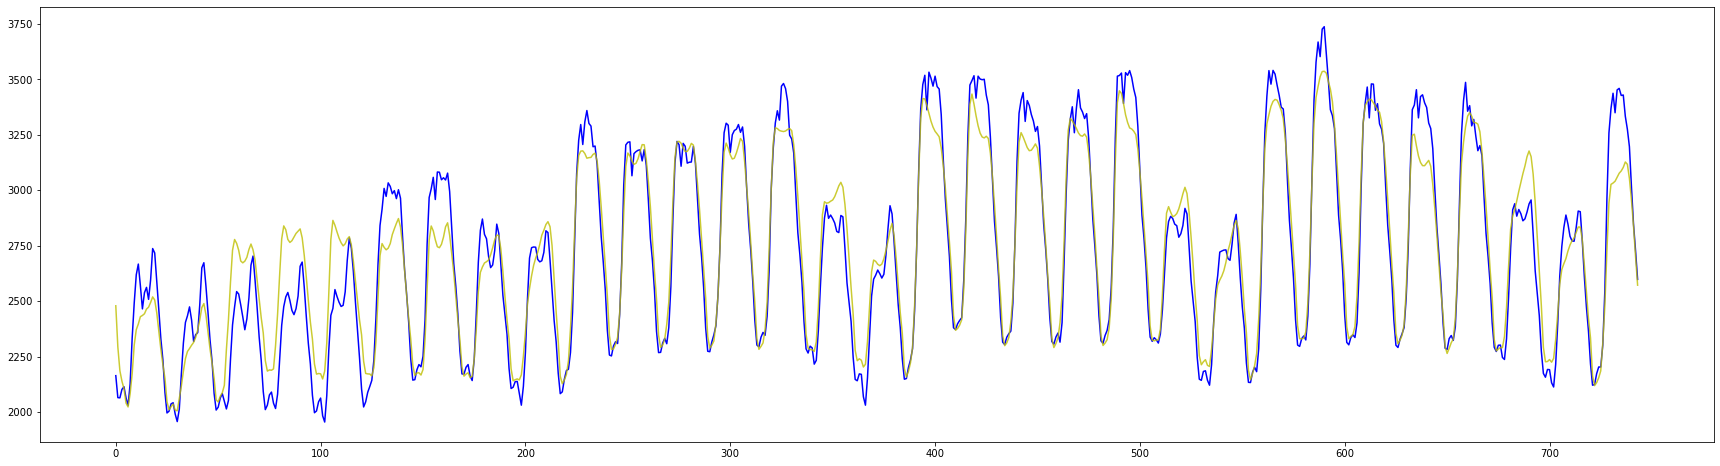

In [177]:
#テストデータ(青)と予測(黄色)を描画
plt.figure(figsize=(30,8))
plt.plot(y_t, c="b")
plt.plot(y_test_pred, c="y", alpha=0.8)
plt.show()

正しい気温データの場合は上記のような予測

In [179]:
%%time
neuron = 256
actfunc = "tanh"
dropout = 0.2
epochs = 300

model_temp = Sequential()
model_temp.add(GRU(neuron, activation=actfunc, batch_input_shape=(None, timesteps, x_train_temp.shape[2]), return_sequences=True))
model_temp.add(Dropout(dropout))
model_temp.add(GRU(neuron, activation="relu"))
model_temp.add(Dropout(dropout))
model_temp.add(Dense(y_train_temp.shape[1], activation="linear")) 

model_temp.compile(loss="mean_squared_error", optimizer="adam")
early_stopping =  EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5)

history_temp = model_temp.fit(x_train_temp, y_train_temp, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/300
183/183 [==============================] - 42s 212ms/step - loss: 0.0294 - val_loss: 0.0064
Epoch 2/300
183/183 [==============================] - 57s 310ms/step - loss: 0.0084 - val_loss: 0.0076
Epoch 3/300
183/183 [==============================] - 59s 325ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 4/300
183/183 [==============================] - 60s 329ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 5/300
183/183 [==============================] - 60s 331ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 6/300
183/183 [==============================] - 59s 324ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 7/300
183/183 [==============================] - 60s 326ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 8/300
183/183 [==============================] - 59s 324ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 9/300
183/183 [==============================] - 58s 319ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 10/300
183/183 [==============================] - 58s 318m

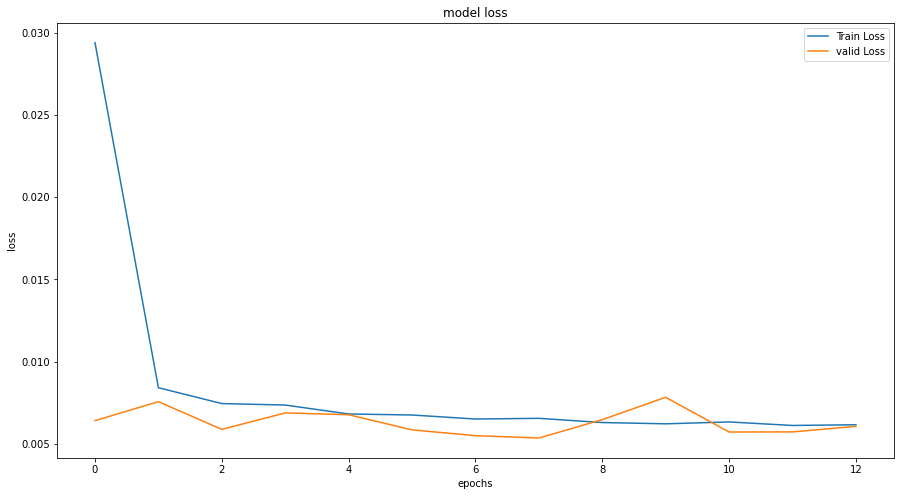

In [199]:
plt.figure(figsize=(15,8))
plt.plot(history_temp.history['loss'], label='Train Loss')
plt.plot(history_temp.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [180]:
pred = model_temp.predict(x_test_temp)

184/184 [==============================] - 8s 35ms/step


In [181]:
pred = np.concatenate([test[timesteps:, :-2], pred], 1)

In [182]:
data_x = []
for i in range(pred.shape[0]-timesteps):
    timedelta_x = []    
    for j in range(pred.shape[1]):
        timedelta_x.append(pred[i:i+timesteps, j])
    timedelta_x = np.array(timedelta_x)
    timedelta_x = timedelta_x.transpose()
    data_x.append(timedelta_x)

x_test_2 = np.array(data_x)

In [195]:
x_test_2.shape

(5874, 6, 5)

In [196]:
pred = model_GRU_stack_2.predict(x_test_2)
pred = np.concatenate([test[timesteps*2:, :-1], pred], 1)
y_test_pred_GRU_stack_2 = mms.inverse_transform(pred)[:738,-1]

y_t = np.concatenate([test[timesteps*2:, :-1], y_test[timesteps:, :]], 1)
y_t = mms.inverse_transform(y_t)[:738,-1]

GRU_RMSE_stack_2 = np.sqrt(mean_squared_error(y_t, y_test_pred_GRU_stack_2))
GRU_MAE_stack_2 = mean_absolute_error(y_t, y_test_pred_GRU_stack_2)
GRU_MAPE_stack_2 = mean_absolute_percentage_error(y_t, y_test_pred_GRU_stack_2)

# 指標出力
print('RMSE:')
print(GRU_RMSE_stack_2)
print('MAE:')
print(GRU_MAE_stack_2) 
print('MAPE:')
print(GRU_MAPE_stack_2) 

184/184 [==============================] - 7s 36ms/step
RMSE:
126.23113912501253
MAE:
97.78679478976139
MAPE:
0.03578444777987563


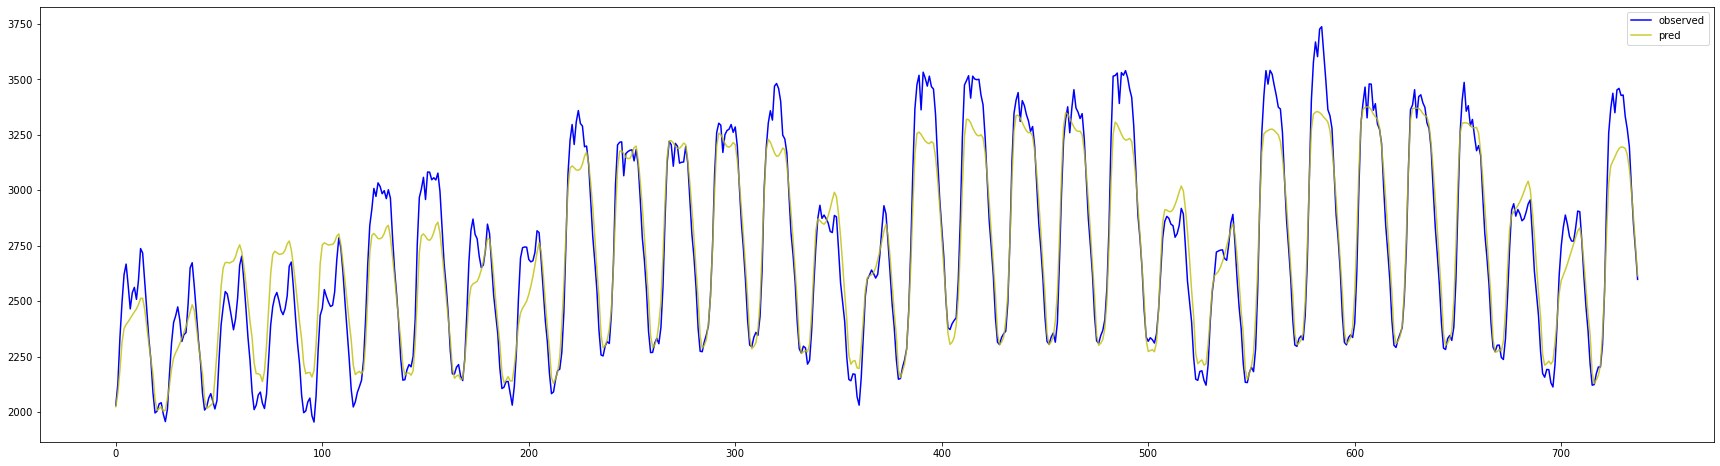

In [198]:
#テストデータ(青)と予測(黄色)を描画
plt.figure(figsize=(30,8))
plt.plot(y_t, c="b", label="observed")
plt.plot(y_test_pred_GRU_stack_2, c="y", alpha=0.8, label="pred")
plt.legend()
plt.show()

## GRU_stack_3

In [316]:
%%time
neuron = 256
actfunc = "tanh"
dropout = 0.2
epochs = 300

model_GRU_stack_3 = Sequential()
model_GRU_stack_3.add(GRU(neuron, activation=actfunc, batch_input_shape=(None, timesteps, x_train.shape[2]), return_sequences=True))
model_GRU_stack_3.add(Dropout(dropout))
model_GRU_stack_3.add(GRU(neuron, activation=actfunc, batch_input_shape=(None, timesteps, x_train.shape[2]), return_sequences=True))
model_GRU_stack_3.add(Dropout(dropout))
model_GRU_stack_3.add(GRU(neuron, activation="relu"))
model_GRU_stack_3.add(Dropout(dropout))
model_GRU_stack_3.add(Dense(y_train.shape[1], activation="linear")) 

model_GRU_stack_3.compile(loss="mean_squared_error", optimizer="adam")
early_stopping =  EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5)

history_GRU_stack_3 = model_GRU_stack_3.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/300
176/176 [==============================] - 19s 77ms/step - loss: 0.0283 - val_loss: 0.0112
Epoch 2/300
176/176 [==============================] - 10s 55ms/step - loss: 0.0130 - val_loss: 0.0114
Epoch 3/300
176/176 [==============================] - 12s 67ms/step - loss: 0.0109 - val_loss: 0.0069
Epoch 4/300
 39/176 [=====>........................] - ETA: 9s - loss: 0.0094

KeyboardInterrupt: 

In [ ]:
time_GRU_stack_3 = 

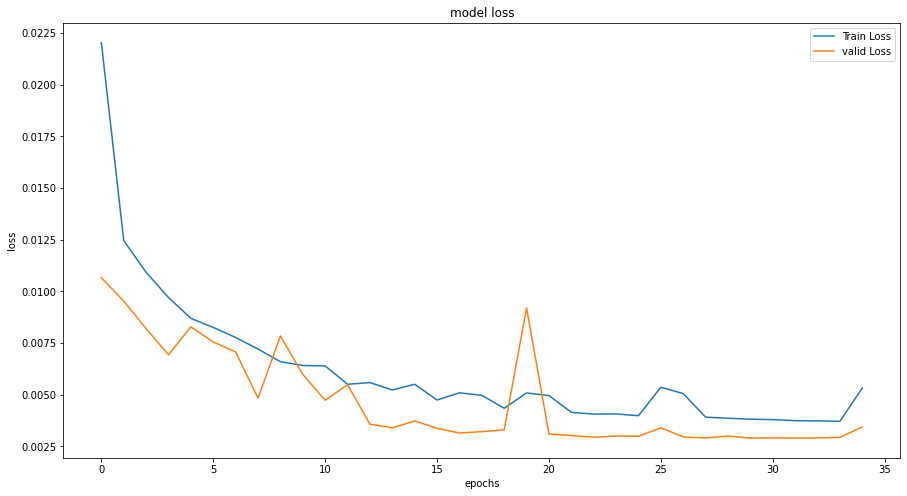

In [312]:
plt.figure(figsize=(15,8))
plt.plot(history_GRU_stack_3.history['loss'], label='Train Loss')
plt.plot(history_GRU_stack_3.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [313]:
y_test_pred_GRU_stack_3 = model_GRU_stack_3.predict(x_test)
y_test_pred_GRU_stack_3 = y_mms.inverse_transform(y_test_pred_GRU_stack_3)
y_test_pred_GRU_stack_3 = y_test_pred_GRU_stack_3[:,8]
y_t = y_mms.inverse_transform(y_test)
y_t = y_t[:,8]

GRU_RMSE_stack_3 = np.sqrt(mean_squared_error(y_t, y_test_pred_GRU_stack_3))
GRU_MAE_stack_3 = mean_absolute_error(y_t, y_test_pred_GRU_stack_3)
GRU_MAPE_stack_3 = mean_absolute_percentage_error(y_t, y_test_pred_GRU_stack_3)

# 指標出力
print('RMSE:')
print(GRU_RMSE_stack_3)
print('MAE:')
print(GRU_MAE_stack_3) 
print('MAPE:')
print(GRU_MAPE_stack_3) 

220/220 [==============================] - 3s 12ms/step
RMSE:
191.46118206224608
MAE:
141.41008771929825
MAPE:
0.04557571883172575


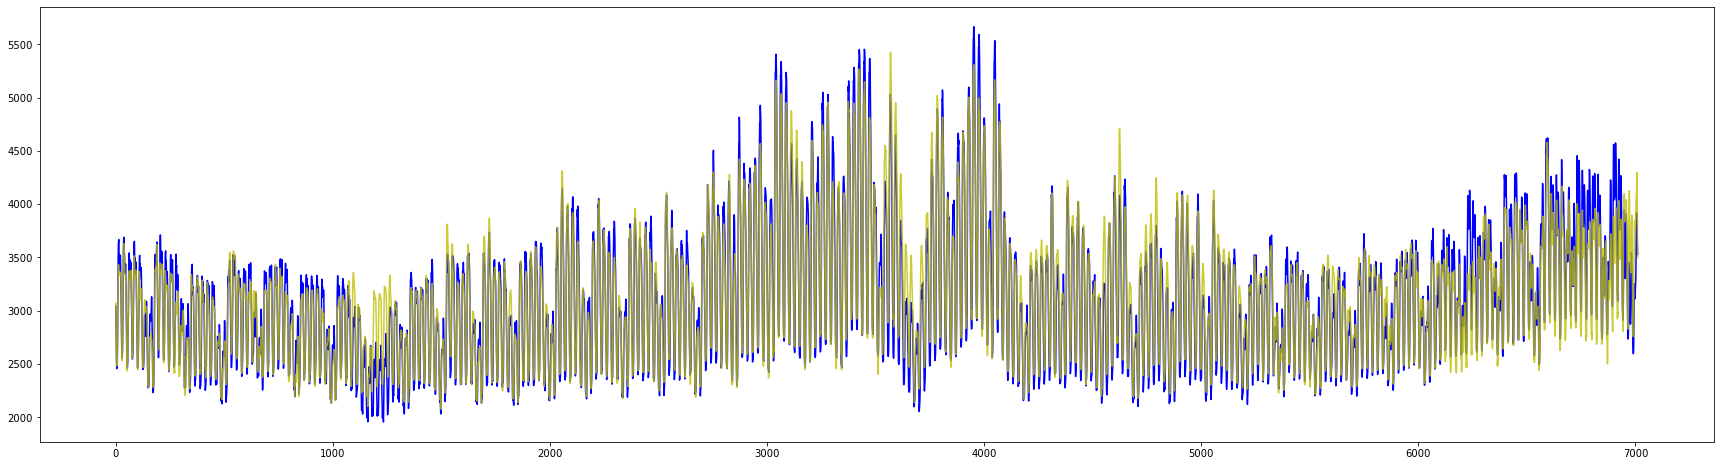

In [314]:
#テストデータ(青)と予測(黄色)を描画
plt.figure(figsize=(30,8))
plt.plot(y_t, c="b")
plt.plot(y_test_pred_GRU_stack_3, c="y", alpha=0.8)
plt.show()

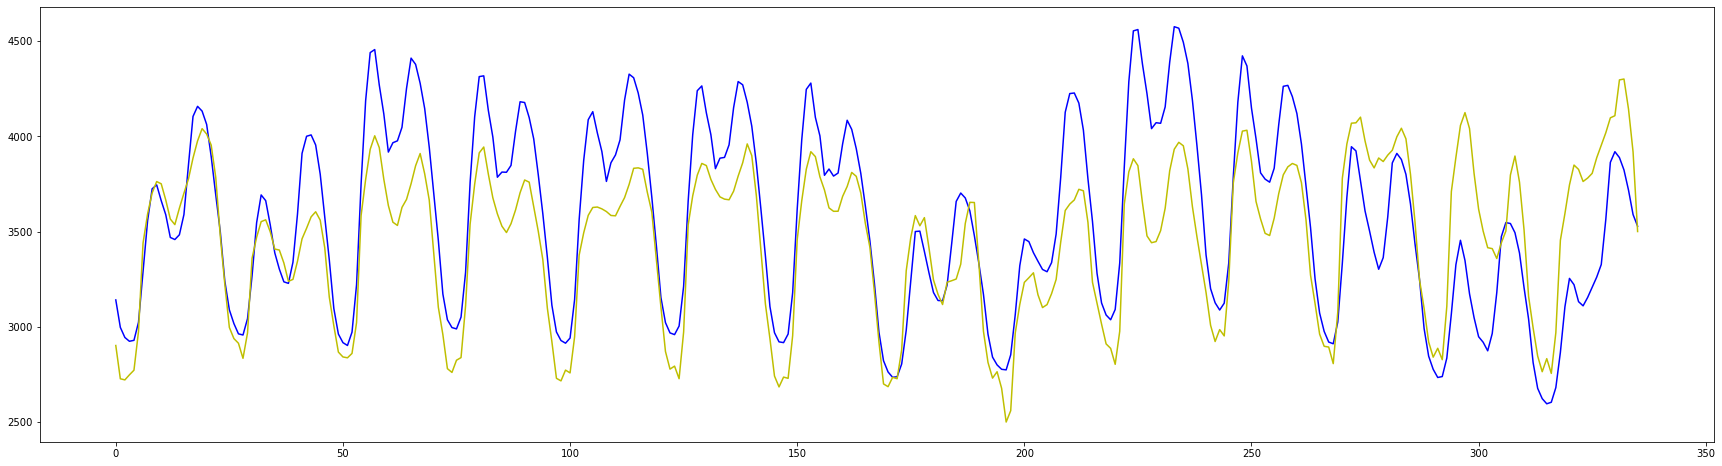

In [315]:
# 後ろから2週間分(24*7*2)のデータだけ描画
plt.figure(figsize=(30,8))
plt.plot(y_t[-336:], c="b")
plt.plot(y_test_pred_GRU_stack_3[-336:], c="y")
plt.show()

## LSTM_stack_2

In [302]:
%%time
#LSTMモデル作成
neuron = 256
actfunc = "tanh"
dropout = 0.2
epochs = 300

model_LSTM_stack_2 = Sequential()
model_LSTM_stack_2.add(LSTM(neuron, activation=actfunc, batch_input_shape=(None, timesteps, x_train.shape[2]), return_sequences=True))
model_LSTM_stack_2.add(Dropout(dropout))
model_LSTM_stack_2.add(LSTM(neuron, activation=actfunc))
model_LSTM_stack_2.add(Dropout(dropout))
model_LSTM_stack_2.add(Dense(y_train.shape[1], activation="linear")) 

model_LSTM_stack_2.compile(loss="mean_squared_error", optimizer="adam")
early_stopping =  EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5)

history_LSTM_stack_2 = model_LSTM_stack_2.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/300
176/176 [==============================] - 17s 70ms/step - loss: 0.0294 - val_loss: 0.0139
Epoch 2/300
176/176 [==============================] - 11s 65ms/step - loss: 0.0140 - val_loss: 0.0097
Epoch 3/300
176/176 [==============================] - 14s 80ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 4/300
176/176 [==============================] - 15s 84ms/step - loss: 0.0099 - val_loss: 0.0074
Epoch 5/300
176/176 [==============================] - 17s 94ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 6/300
176/176 [==============================] - 17s 96ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 7/300
176/176 [==============================] - 19s 106ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 8/300
176/176 [==============================] - 18s 101ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 9/300
176/176 [==============================] - 19s 106ms/step - loss: 0.0072 - val_loss: 0.0054
Epoch 10/300
176/176 [==============================] - 19s 106ms/step

In [304]:
time_LSTM_stack_2 = 539

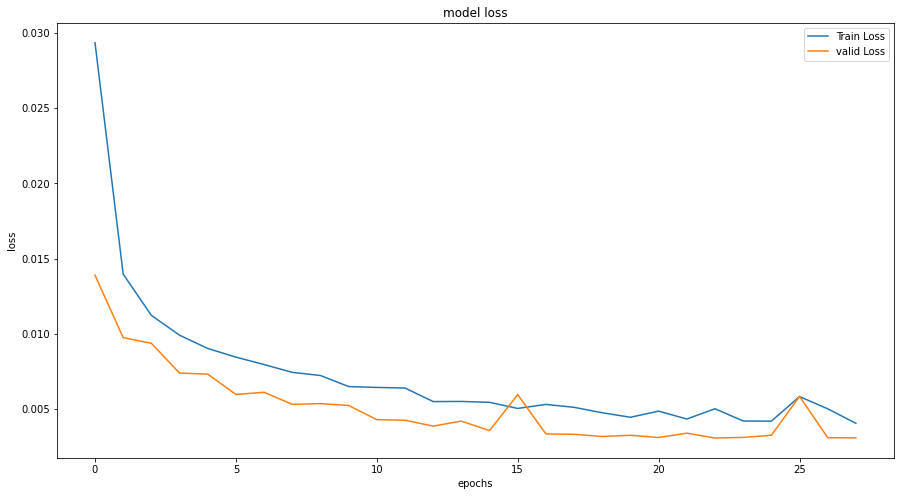

In [305]:
plt.figure(figsize=(15,8))
plt.plot(history_LSTM_stack_2.history['loss'], label='Train Loss')
plt.plot(history_LSTM_stack_2.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [307]:
y_test_pred_LSTM_stack_2 = model_LSTM_stack_2.predict(x_test)
y_test_pred_LSTM_stack_2 = y_mms.inverse_transform(y_test_pred_LSTM_stack_2)
y_test_pred_LSTM_stack_2 = y_test_pred_LSTM_stack_2[:,8]
y_t = y_mms.inverse_transform(y_test)
y_t = y_t[:,8]

LSTM_RMSE_stack_2 = np.sqrt(mean_squared_error(y_t, y_test_pred_LSTM_stack_2))
LSTM_MAE_stack_2 = mean_absolute_error(y_t, y_test_pred_LSTM_stack_2)
LSTM_MAPE_stack_2 = mean_absolute_percentage_error(y_t, y_test_pred_LSTM_stack_2)

# 指標出力
print('RMSE:')
print(LSTM_RMSE_stack_2)
print('MAE:')
print(LSTM_MAE_stack_2) 
print('MAPE:')
print(LSTM_MAPE_stack_2) 

220/220 [==============================] - 7s 23ms/step
RMSE:
191.728720012337
MAE:
139.85262991443133
MAPE:
0.043789830010155455


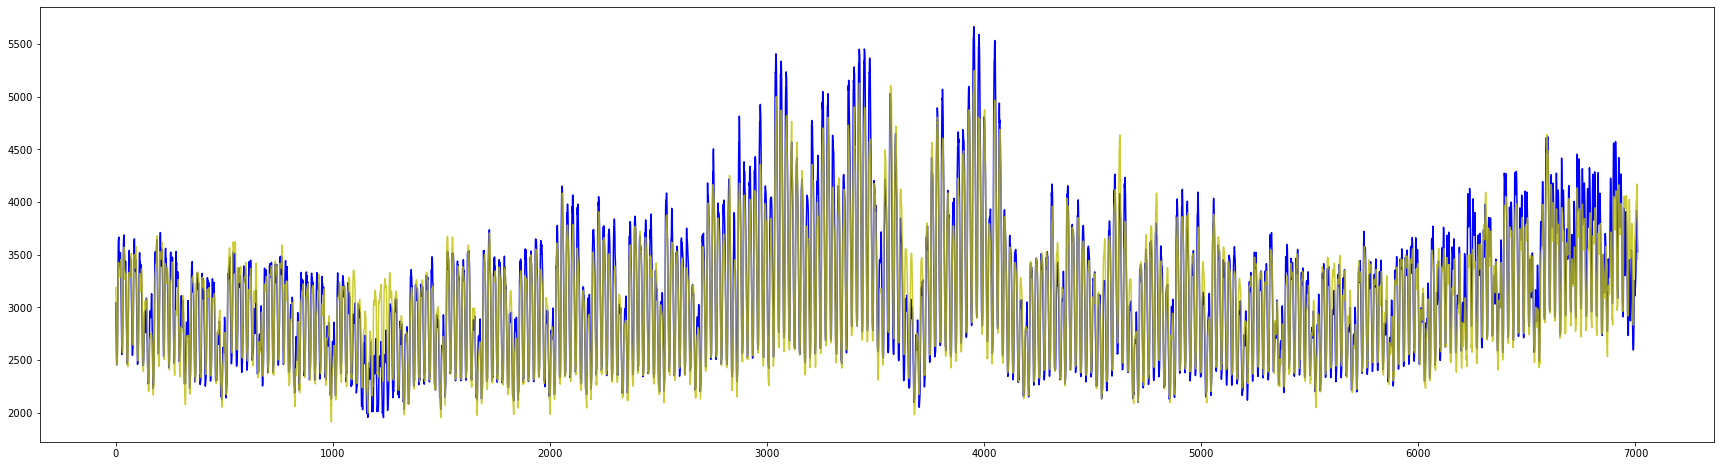

In [309]:
#テストデータ(青)と予測(黄色)を描画
plt.figure(figsize=(30,8))
plt.plot(y_t, c="b")
plt.plot(y_test_pred_LSTM_stack_2, c="y", alpha=0.8)
plt.show()

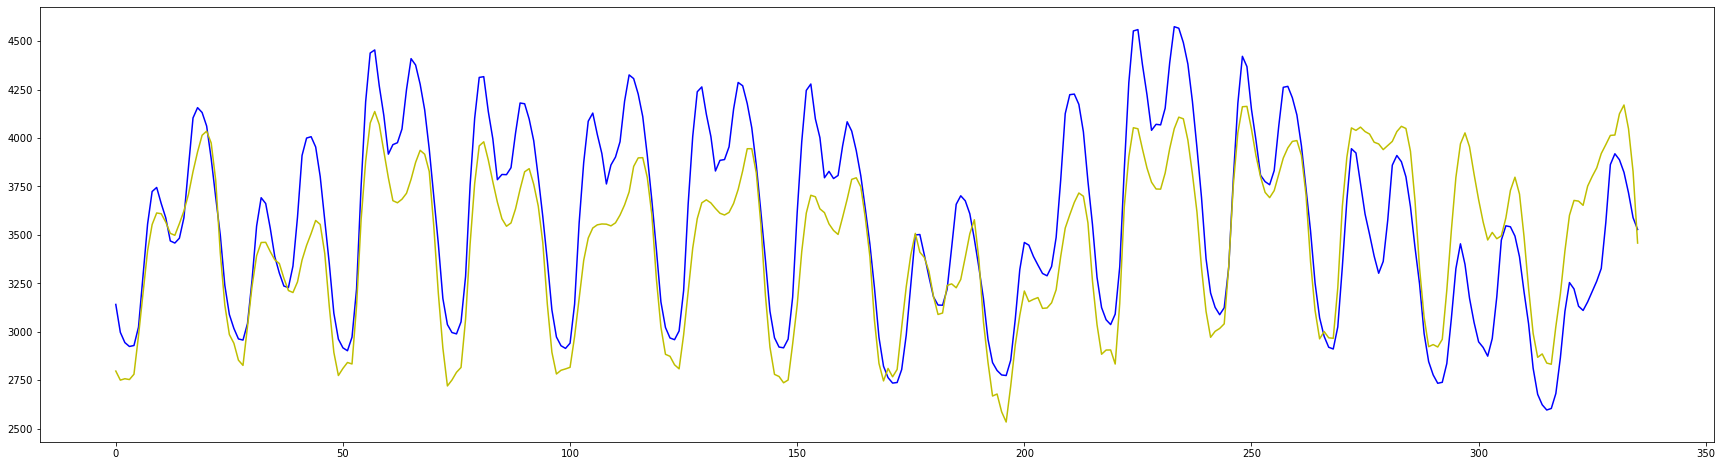

In [310]:
# 後ろから2週間分(24*7*2)のデータだけ描画
plt.figure(figsize=(30,8))
plt.plot(y_t[-336:], c="b")
plt.plot(y_test_pred_LSTM_stack_2[-336:], c="y")
plt.show()

## 可視化

<BarContainer object of 1 artists>

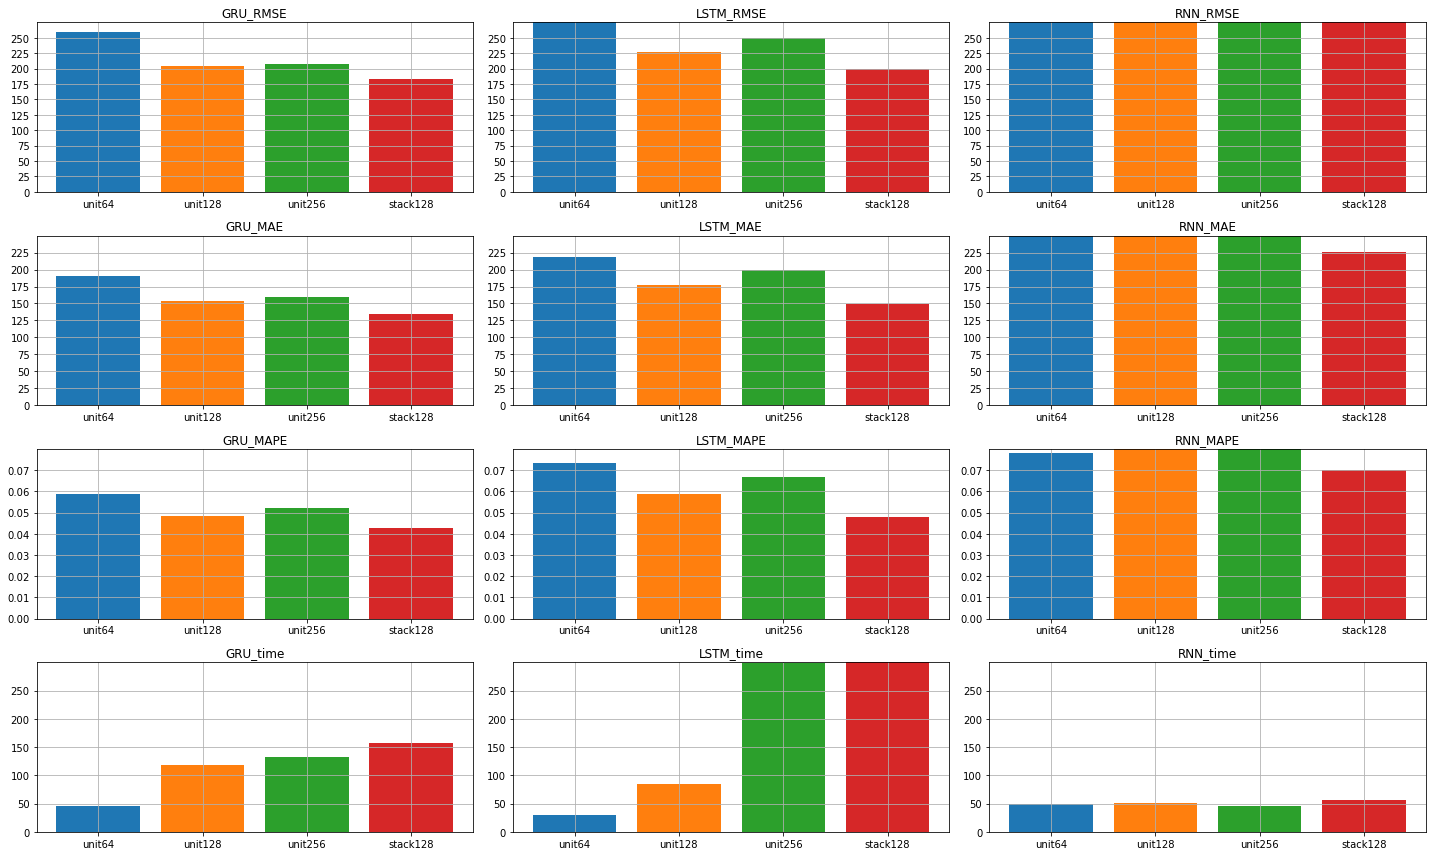

In [104]:
x = ["unit64", "unit128", "unit256", "stack128"]
fig, axis = plt.subplots(4, 3, tight_layout=True, figsize=(20,12))

axis[0,0].set_title("GRU_RMSE")
axis[0,0].set_ylim(0, 275)
axis[0,0].set_yticks(np.arange(0,275, 25))
#axis[0,0].set_xticks(np.arange(0, 4, 1))
axis[0,0].grid()
axis[0,0].bar(x[0], GRU_RMSE_64)
axis[0,0].bar(x[1], GRU_RMSE_128)
axis[0,0].bar(x[2], GRU_RMSE_256)
axis[0,0].bar(x[3], GRU_RMSE_stack)

axis[1,0].set_title("GRU_MAE")
axis[1,0].set_ylim(0, 250)
axis[1,0].set_yticks(np.arange(0,250, 25))
#axis[1,0].set_xticks(np.arange(0, 4, 1))
axis[1,0].grid()
axis[1,0].bar(x[0], GRU_MAE_64)
axis[1,0].bar(x[1], GRU_MAE_128)
axis[1,0].bar(x[2], GRU_MAE_256)
axis[1,0].bar(x[3], GRU_MAE_stack)

axis[2,0].set_title("GRU_MAPE")
axis[2,0].set_ylim(0, 0.08)
axis[2,0].set_yticks(np.arange(0, 0.08, 0.01))
#axis[2,0].set_xticks(np.arange(0, 4, 1))
axis[2,0].grid()
axis[2,0].bar(x[0], GRU_MAPE_64)
axis[2,0].bar(x[1], GRU_MAPE_128)
axis[2,0].bar(x[2], GRU_MAPE_256)
axis[2,0].bar(x[3], GRU_MAPE_stack)

axis[3,0].set_title("GRU_time")
axis[3,0].set_ylim(0, 300)
axis[3,0].set_yticks(np.arange(0, 300, 50))
#axis[3,0].set_xticks(np.arange(0, 4, 1))
axis[3,0].grid()
axis[3,0].bar(x[0], time_GRU_64)
axis[3,0].bar(x[1], time_GRU_128)
axis[3,0].bar(x[2], time_GRU_256)
axis[3,0].bar(x[3], time_GRU_stack)


axis[0,1].set_title("LSTM_RMSE")
axis[0,1].set_ylim(0, 275)
axis[0,1].set_yticks(np.arange(0,275, 25))
#axis[0,1].set_xticks(np.arange(0, 4, 1))
axis[0,1].grid()
axis[0,1].bar(x[0], LSTM_RMSE_64)
axis[0,1].bar(x[1], LSTM_RMSE_128)
axis[0,1].bar(x[2], LSTM_RMSE_256)
axis[0,1].bar(x[3], LSTM_RMSE_stack)

axis[1,1].set_title("LSTM_MAE")
axis[1,1].set_ylim(0, 250)
axis[1,1].set_yticks(np.arange(0,250, 25))
#axis[1,1].set_xticks(np.arange(0, 4, 1))
axis[1,1].grid()
axis[1,1].bar(x[0], LSTM_MAE_64)
axis[1,1].bar(x[1], LSTM_MAE_128)
axis[1,1].bar(x[2], LSTM_MAE_256)
axis[1,1].bar(x[3], LSTM_MAE_stack)

axis[2,1].set_title("LSTM_MAPE")
axis[2,1].set_ylim(0, 0.08)
axis[2,1].set_yticks(np.arange(0, 0.08, 0.01))
#axis[2,1].set_xticks(np.arange(0, 4, 1))
axis[2,1].grid()
axis[2,1].bar(x[0], LSTM_MAPE_64)
axis[2,1].bar(x[1], LSTM_MAPE_128)
axis[2,1].bar(x[2], LSTM_MAPE_256)
axis[2,1].bar(x[3], LSTM_MAPE_stack)

axis[3,1].set_title("LSTM_time")
axis[3,1].set_ylim(0, 300)
axis[3,1].set_yticks(np.arange(0, 300, 50))
#axis[3,1].set_xticks(np.arange(0, 4, 1))
axis[3,1].grid()
axis[3,1].bar(x[0], time_LSTM_64)
axis[3,1].bar(x[1], time_LSTM_128)
axis[3,1].bar(x[2], time_LSTM_256)
axis[3,1].bar(x[3], time_LSTM_stack)


axis[0,2].set_title("RNN_RMSE")
axis[0,2].set_ylim(0, 275)
axis[0,2].set_yticks(np.arange(0,275, 25))
#axis[0,2].set_xticks(np.arange(0, 4, 1))
axis[0,2].grid()
axis[0,2].bar(x[0], RNN_RMSE_64)
axis[0,2].bar(x[1], RNN_RMSE_128)
axis[0,2].bar(x[2], RNN_RMSE_256)
axis[0,2].bar(x[3], RNN_RMSE_stack)

axis[1,2].set_title("RNN_MAE")
axis[1,2].set_ylim(0, 250)
axis[1,2].set_yticks(np.arange(0,250, 25))
#axis[1,2].set_xticks(np.arange(0, 4, 1))
axis[1,2].grid()
axis[1,2].bar(x[0], RNN_MAE_64)
axis[1,2].bar(x[1], RNN_MAE_128)
axis[1,2].bar(x[2], RNN_MAE_256)
axis[1,2].bar(x[3], RNN_MAE_stack)

axis[2,2].set_title("RNN_MAPE")
axis[2,2].set_ylim(0, 0.08)
axis[2,2].set_yticks(np.arange(0, 0.08, 0.01))
#axis[2,2].set_xticks(np.arange(0, 4, 1))
axis[2,2].grid()
axis[2,2].bar(x[0], RNN_MAPE_64)
axis[2,2].bar(x[1], RNN_MAPE_128)
axis[2,2].bar(x[2], RNN_MAPE_256)
axis[2,2].bar(x[3], RNN_MAPE_stack)

axis[3,2].set_title("RNN_time")
axis[3,2].set_ylim(0, 300)
axis[3,2].set_yticks(np.arange(0, 300, 50))
#axis[3,2].set_xticks(np.arange(0, 4, 1))
axis[3,2].grid()
axis[3,2].bar(x[0], time_RNN_64)
axis[3,2].bar(x[1], time_RNN_128)
axis[3,2].bar(x[2], time_RNN_256)
axis[3,2].bar(x[3], time_RNN_stack)